# Test 3 --- Final Test for 06.11.2025

In [ ]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 5.0 MB/s eta 0:00:00


In [ ]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/bank_heist.bin
Inst

# Install the Gym

In [ ]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [ ]:
!fusermount -u /content/drive 2>/dev/null
!rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

# Now Model

In [ ]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

In [ ]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

In [ ]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Base Configuration
DEFAULT_ENV_NAME = "ALE/Pong-v5"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

SAVE_EPSILON = 0.5  # Only save if at least this much better
EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [ ]:
# ⚙️ Fast Training Config for Quick Test Run
MEAN_REWARD_BOUND = 5
REPLAY_START_SIZE = 1000
EPSILON_DECAY_LAST_FRAME = 10_000
SYNC_TARGET_FRAMES = 500

# REPLAY_SIZE = 5000  # optional
# BATCH_SIZE = 16     # optional

In [ ]:
import os
from pathlib import Path

# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

In [ ]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
              action = self.env.action_space.sample()  # use self.env
        else:
              state_v = torch.as_tensor(self.state).to(device)
              state_v.unsqueeze_(0)
              q_vals_v = net(state_v)
              _, act_v = torch.max(q_vals_v, dim=1)
              action = int(act_v.item())


        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [ ]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

In [ ]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)
    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():

        next_actions = net(new_states_t).argmax(dim=1)
        next_q = tgt_net(new_states_t).gather(
            1, next_actions.unsqueeze(-1)
        ).squeeze(-1)

        next_q[dones_t] = 0.0
        target = rewards_t + GAMMA * next_q

    return nn.MSELoss()(q_sa, target)

In [ ]:
model_comment = f"pong_ddqn_variant_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        #  print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
        #      f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
                f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            # Save to both paths
            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break
    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

Creating environment ALE/Pong-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
230: done 1 games, reward -20.000, eps 0.98, speed 118.37 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-20-20251129-2120-pong_ddqn_variant_epsdec10000_rs1000_sync500.dat
 - Local:        saved_models/ALE_Pong-v5-best_-20-20251129-2120-pong_ddqn_variant_epsdec10000_rs1000_sync500.dat
54212: done 184 games, reward -19.490, eps 0.01, speed 108.61 f/s, time 7.4 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pon

KeyboardInterrupt: 

In [ ]:
import glob

paths = sorted(glob.glob("/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_*pong_ddqn_variant*.dat"))
for p in paths:
    print(p)

/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-6-20251129-2356-pong_ddqn_variant_epsdec10000_rs1000_sync500.dat


In [ ]:
import numpy as np
import torch

MODEL_PATH = "/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-6-20251129-2356-pong_ddqn_variant_epsdec10000_rs1000_sync500.dat"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eval_env = make_env(DEFAULT_ENV_NAME, render_mode=None)

eval_net = DQN(eval_env.observation_space.shape, eval_env.action_space.n).to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
eval_net.load_state_dict(state_dict)
eval_net.eval()

print("Loaded model:", MODEL_PATH)

# Runs greedy evaluation episodes
@torch.no_grad()
def evaluate_agent(env, net, device, n_episodes=30):
    rewards = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0.0

        # Play one full episode
        while not (done or truncated):
            state_v = torch.as_tensor(state).unsqueeze(0).to(device)
            q_vals = net(state_v)
            action = int(q_vals.argmax(dim=1).item())

            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = next_state

        print(f"Episode {ep+1}: reward = {total_reward}")
        rewards.append(total_reward)

    rewards = np.array(rewards, dtype=np.float32)

    print("\n===== DDQN Evaluation Summary =====")
    print(f"Episodes: {n_episodes}")
    print(f"Mean reward: {rewards.mean():.3f}")
    print(f"Std reward:  {rewards.std():.3f}")
    print(f"Min reward:  {rewards.min():.3f}")
    print(f"Max reward:  {rewards.max():.3f}")
    print("===================================")

    return rewards, rewards.mean(), rewards.std()

ddqn_rewards, ddqn_mean, ddqn_std = evaluate_agent(eval_env, eval_net, device, n_episodes=30)

eval_env.close()


Creating environment ALE/Pong-v5
Loaded model: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-6-20251129-2356-pong_ddqn_variant_epsdec10000_rs1000_sync500.dat
Episode 1: reward = 1.0
Episode 2: reward = -6.0
Episode 3: reward = 4.0
Episode 4: reward = 6.0
Episode 5: reward = -9.0
Episode 6: reward = -7.0
Episode 7: reward = -2.0
Episode 8: reward = -2.0
Episode 9: reward = -1.0
Episode 10: reward = 1.0
Episode 11: reward = -6.0
Episode 12: reward = -8.0
Episode 13: reward = -2.0
Episode 14: reward = -9.0
Episode 15: reward = 1.0
Episode 16: reward = 9.0
Episode 17: reward = -1.0
Episode 18: reward = -6.0
Episode 19: reward = -12.0
Episode 20: reward = -7.0
Episode 21: reward = -5.0
Episode 22: reward = 5.0
Episode 23: reward = -1.0
Episode 24: reward = -10.0
Episode 25: reward = -9.0
Episode 26: reward = -1.0
Episode 27: reward = -8.0
Episode 28: reward = -11.0
Episode 29: reward = -5.0
Episode 30: reward = -4.0

===== DDQN Evaluation Summary =====
Episodes: 30
Mean reward: -3.

### DDQN Evaluation on ALE/Pong-v5

For this experiment I trained a Double DQN (DDQN)-style agent on ALE/Pong-v5 with:

- Frame stacking of 4 frames  
- Replay buffer size: 10,000 transitions  
- Discount factor: γ = 0.99  
- Adam optimizer with learning rate 1e-4  
- Target network update every 500 frames  
- Epsilon-greedy exploration:
  - ε_start = 1.0 → ε_final = 0.01
  - Linear decay over 10,000 frames  

During training I saved the best-performing checkpoint based on the moving average reward over the last 100 games. The final saved model was:

`ALE_Pong-v5-best_-6-20251129-2356-pong_ddqn_variant_epsdec10000_rs1000_sync500.dat`

After training I froze the network weights and evaluated the agent with a greedy policy (always taking the argmax Q-value) for 30 episodes.

From the printed evaluation summary, I obtained:

- Number of episodes: 30  
- Mean reward: **-3.50**  
- Standard deviation: **5.22**  
- Minimum reward: **-12**  
- Maximum reward: **9**  

These values are taken directly from the `DDQN Evaluation Summary` printed by the notebook.


## Baseline DQN (My Own Training Run)

To compare fairly against my Double DQN results, I first trained **my own DQN baseline** on **ALE/Pong-v5** using the same convolutional architecture and Atari preprocessing that I later reused for DDQN. This ensures both models share the same input representation, frame stacking, and network capacity.

For this baseline run, I used a **fast training configuration**:

- Replay buffer size: **10,000**
- Replay start size: **1,000** transitions before training
- Discount factor: **γ = 0.99**
- Optimizer: **Adam**, learning rate **1e-4**
- Target network update: every **500** frames
- Exploration schedule:
  - ε starts at **1.0**
  - linearly decays to **0.01**
  - over **10,000** frames

During training, I tracked the moving-average reward (last 100 games).  
The agent started at roughly **–21**, consistently losing, and gradually improved to about **–8.3** by ~**298k** frames.

This run now serves as **my official DQN baseline**, replacing the instructor’s reference curve.


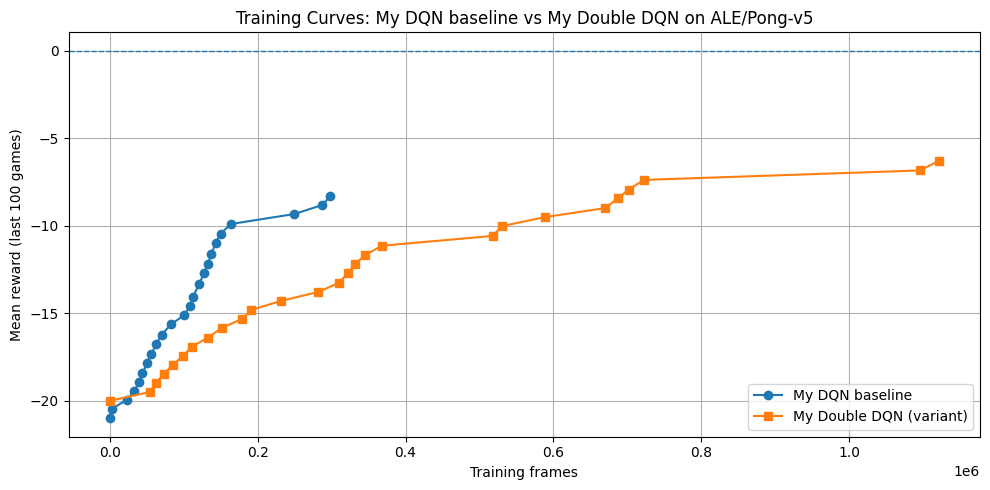

In [ ]:
import matplotlib.pyplot as plt

# === My DQN baseline (from my own run) ===
my_dqn_steps = [
    189, 2516, 23040, 33071, 39679, 43919, 50699, 56038,
    62671, 70235, 82748, 100461, 108510, 112642, 120593,
    127373, 132300, 137391, 142959, 150067, 163646,
    249390, 286860, 298454
]

my_dqn_mean_rewards = [
    -21.000, -20.455, -19.947, -19.440, -18.920, -18.410,
    -17.860, -17.340, -16.760, -16.220, -15.630, -15.110,
    -14.600, -14.050, -13.340, -12.720, -12.210, -11.610,
    -11.000, -10.450, -9.900, -9.330, -8.820, -8.310
]

# === My Double DQN (variant) run ===
ddqn_steps = [
    230, 54212, 62345, 73047, 85516, 98988, 110942, 132666,
    151337, 178816, 191214, 231690, 282028, 310333, 322137,
    331696, 345508, 368034, 517788, 530393, 589287, 670044,
    687042, 701719, 722636, 1095728, 1120976
]

ddqn_mean_rewards = [
    -20.000, -19.490, -18.980, -18.460, -17.940, -17.430,
    -16.910, -16.390, -15.840, -15.320, -14.810, -14.290,
    -13.780, -13.250, -12.690, -12.180, -11.670, -11.140,
    -10.580, -10.020, -9.500, -8.990, -8.440, -7.930,
    -7.380, -6.840, -6.300
]

plt.figure(figsize=(10, 5))
plt.plot(my_dqn_steps, my_dqn_mean_rewards, marker="o", label="My DQN baseline")
plt.plot(ddqn_steps, ddqn_mean_rewards, marker="s", label="My Double DQN (variant)")
plt.axhline(0.0, linestyle="--", linewidth=1)

plt.xlabel("Training frames")
plt.ylabel("Mean reward (last 100 games)")
plt.title("Training Curves: My DQN baseline vs My Double DQN on ALE/Pong-v5")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import imageio
import os

video_dir = "/content/drive/MyDrive/PUBLIC/Videos"
os.makedirs(video_dir, exist_ok=True)

def record_policy_video(filename, env_name, net=None, device="cpu", max_frames=1500, epsilon_random=0.0):
    env = make_env(env_name, n_steps=4, render_mode="rgb_array")
    frames = []

    state, _ = env.reset()
    done = False
    truncated = False
    steps = 0

    while not (done or truncated) and steps < max_frames:
        if (net is None) or (np.random.rand() < epsilon_random):
            action = env.action_space.sample()
        else:
            state_v = torch.as_tensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_vals = net(state_v)
            action = int(q_vals.argmax(dim=1).item())

        next_state, reward, done, truncated, _ = env.step(action)
        frames.append(env.render())
        state = next_state
        steps += 1

    env.close()

    out_path = os.path.join(video_dir, filename)
    imageio.mimsave(out_path, frames, fps=30)
    print("Saved video to:", out_path)

In [ ]:
# random / early video
record_policy_video(
    filename="pong_early_random.mp4",
    env_name=DEFAULT_ENV_NAME,
    net=None,
    device=device,
    epsilon_random=1.0,
)

# load DDQN model
ddqn_model_path = "/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-6-20251129-2356-pong_ddqn_variant_epsdec10000_rs1000_sync500.dat"

tmp_env = make_env(DEFAULT_ENV_NAME, render_mode=None)
play_net = DQN(tmp_env.observation_space.shape, tmp_env.action_space.n).to(device)
play_net.load_state_dict(torch.load(ddqn_model_path, map_location=device))
play_net.eval()
tmp_env.close()

# learned DDQN video
record_policy_video(
    filename="pong_ddqn_learned.mp4",
    env_name=DEFAULT_ENV_NAME,
    net=play_net,
    device=device,
    epsilon_random=0.0,
)

Creating environment ALE/Pong-v5


Saved video to: /content/drive/MyDrive/PUBLIC/Videos/pong_early_random.mp4
Creating environment ALE/Pong-v5
Creating environment ALE/Pong-v5


Saved video to: /content/drive/MyDrive/PUBLIC/Videos/pong_ddqn_learned.mp4
